In [1]:
import pandas as pd        
import numpy as np
import re
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

In [3]:
data = pd.read_excel('Pizza_Sale.xlsx')

In [7]:
data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [11]:
data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [13]:
data['pizza_name'].unique()

array(['The Hawaiian Pizza', 'The Classic Deluxe Pizza',
       'The Five Cheese Pizza', 'The Italian Supreme Pizza',
       'The Mexicana Pizza', 'The Thai Chicken Pizza',
       'The Prosciutto and Arugula Pizza', 'The Barbecue Chicken Pizza',
       'The Greek Pizza', 'The Spinach Supreme Pizza',
       'The Green Garden Pizza', 'The Italian Capocollo Pizza',
       'The Spicy Italian Pizza', 'The Spinach Pesto Pizza',
       'The Vegetables + Vegetables Pizza', 'The Southwest Chicken Pizza',
       'The California Chicken Pizza', 'The Pepperoni Pizza',
       'The Chicken Pesto Pizza', 'The Big Meat Pizza',
       'The Soppressata Pizza', 'The Four Cheese Pizza',
       'The Napolitana Pizza', 'The Calabrese Pizza',
       'The Italian Vegetables Pizza', 'The Mediterranean Pizza',
       'The Pepper Salami Pizza', 'The Spinach and Feta Pizza',
       'The Sicilian Pizza', 'The Chicken Alfredo Pizza',
       'The Pepperoni, Mushroom, and Peppers Pizza',
       'The Brie Carre Pizza'

In [15]:
data['pizza_name_id'].unique()

array(['hawaiian_m', 'classic_dlx_m', 'five_cheese_l', 'ital_supr_l',
       'mexicana_m', 'thai_ckn_l', 'ital_supr_m', 'prsc_argla_l',
       'bbq_ckn_s', 'the_greek_s', 'spinach_supr_s', 'classic_dlx_s',
       'green_garden_s', 'ital_cpcllo_l', 'ital_supr_s', 'mexicana_s',
       'spicy_ital_l', 'spin_pesto_l', 'veggie_veg_s', 'mexicana_l',
       'southw_ckn_l', 'bbq_ckn_l', 'cali_ckn_l', 'cali_ckn_m',
       'pepperoni_l', 'cali_ckn_s', 'ckn_pesto_l', 'big_meat_s', nan,
       'calabrese_m', 'four_cheese_m', 'ital_veggie_s', 'mediterraneo_m',
       'peppr_salami_s', 'spinach_fet_l', 'napolitana_l', 'sicilian_l',
       'ital_cpcllo_m', 'southw_ckn_s', 'bbq_ckn_m', 'pepperoni_m',
       'prsc_argla_s', 'sicilian_m', 'veggie_veg_l', 'ckn_alfredo_s',
       'pepperoni_s', 'green_garden_l', 'green_garden_m', 'pep_msh_pep_l',
       'hawaiian_s', 'four_cheese_l', 'peppr_salami_m', 'ckn_alfredo_m',
       'peppr_salami_l', 'spin_pesto_s', 'thai_ckn_m', 'classic_dlx_l',
       'ckn_pest

In [19]:
data['pizza_name'] = data['pizza_name'].fillna("Unknown Pizza")

In [21]:
name_abbreviations = {
    'The Hawaiian Pizza': 'hawaiian', 
    'The Classic Deluxe Pizza': 'classic_dlx',
    'The Five Cheese Pizza': 'five_cheese', 
    'The Italian Supreme Pizza': 'ital_supr',
    'The Mexicana Pizza': 'mexicana', 
    'The Thai Chicken Pizza': 'thai_ckn',
    'The Prosciutto and Arugula Pizza': 'prsc_argla', 
    'The Barbecue Chicken Pizza': 'bbq_ckn',
    'The Greek Pizza': 'the_greek', 
    'The Spinach Supreme Pizza': 'spinach_supr',
    'The Green Garden Pizza': 'green_garden', 
    'The Italian Capocollo Pizza': 'ital_cpcllo',
    'The Spicy Italian Pizza': 'spicy_ital', 
    'The Spinach Pesto Pizza': 'spin_pesto',
    'The Vegetables + Vegetables Pizza': 'veggie_veg', 
    'The Southwest Chicken Pizza': 'southw_ckn',
    'The California Chicken Pizza': 'cali_ckn', 
    'The Pepperoni Pizza': 'pepperoni',
    'The Chicken Pesto Pizza': 'ckn_pesto', 
    'The Big Meat Pizza': 'big_meat',
    'The Soppressata Pizza': 'soppressata', 
    'The Four Cheese Pizza': 'four_cheese',
    'The Napolitana Pizza': 'napolitana', 
    'The Calabrese Pizza': 'calabrese',
    'The Italian Vegetables Pizza': 'ital_veggie', 
    'The Mediterranean Pizza': 'mediterraneo',
    'The Pepper Salami Pizza': 'peppr_salami', 
    'The Spinach and Feta Pizza': 'spinach_fet',
    'The Sicilian Pizza': 'sicilian', 
    'The Chicken Alfredo Pizza': 'ckn_alfredo',
    'The Pepperoni, Mushroom, and Peppers Pizza': 'pep_msh_pep',
    'The Brie Carre Pizza': 'brie_carre'
}

def create_pizza_name_id(row):
    pizza_name = row['pizza_name']
    pizza_size = row['pizza_size'][0].lower()  # Take the first letter and lowercase
    try:
        name_part = name_abbreviations[pizza_name]
    except KeyError:
        # Handle cases where the name is not in the mapping (e.g., use a default or raise an error)
        name_part = pizza_name.replace("The ", "").replace(" Pizza", "").replace(" ", "_").lower()  # Default: simple cleaning
        print(f"Warning: No abbreviation found for '{pizza_name}'. Using default.")

    return f"{name_part}_{pizza_size}"

# Apply the function to create the pizza_name_id column
data['pizza_name_id'] = data['pizza_name_id'].fillna(data.apply(create_pizza_name_id, axis=1))

print(data)


       pizza_id  order_id  pizza_name_id  quantity           order_date  \
0             1         1     hawaiian_m         1  2015-01-01 00:00:00   
1             2         2  classic_dlx_m         1  2015-01-01 00:00:00   
2             3         2  five_cheese_l         1  2015-01-01 00:00:00   
3             4         2    ital_supr_l         1  2015-01-01 00:00:00   
4             5         2     mexicana_m         1  2015-01-01 00:00:00   
...         ...       ...            ...       ...                  ...   
48615     48616     21348  ckn_alfredo_m         1           31-12-2015   
48616     48617     21348  four_cheese_l         1           31-12-2015   
48617     48618     21348   napolitana_s         1           31-12-2015   
48618     48619     21349     mexicana_l         1           31-12-2015   
48619     48620     21350      bbq_ckn_s         1           31-12-2015   

      order_time  unit_price  total_price pizza_size pizza_category  \
0       11:38:36       13.25

In [23]:
data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            0
dtype: int64

In [25]:
def assign_category(row):
    pizza_name = row['pizza_name']
    if pd.isna(row['pizza_category']): #Check if the value is NaN
        if 'Pizza' in pizza_name:  # Check if "Pizza" is in the name
            if ('Hawaiian' in pizza_name or 'Classic' in pizza_name or 'Big' in pizza_name 
                or 'Greek' in pizza_name or 'Capocollo' in pizza_name or 'Napolitana' in pizza_name or 'Pepperoni' in pizza_name):
                return 'Classic' #Assign 'Pizza' if any of these conditions are true.
            elif 'Chicken' in pizza_name:
                return 'Chicken'
            elif ('Supreme' in pizza_name or 'Calabrese' in pizza_name or 'Brie' in pizza_name or 'Pepper' in pizza_name 
                  or 'Prosciutto' in pizza_name or 'Sicilian' in pizza_name or 'Soppressata' in pizza_name or 'Spicy' in pizza_name):
                return 'Supreme'
            elif ('Cheese' in pizza_name or 'Green' in pizza_name or 'Vegetables' in pizza_name 
                  or 'Mediterranean' in pizza_name or 'Mexicana' in pizza_name or 'Spinach' in pizza_name):
                return 'Veggie'
            else:
                return 'Other' # Default category for other pizzas

    else:
        return row['pizza_category'] #Return the category if it is already present.

data['pizza_category'] = data.apply(assign_category, axis=1)
print(data)

       pizza_id  order_id  pizza_name_id  quantity           order_date  \
0             1         1     hawaiian_m         1  2015-01-01 00:00:00   
1             2         2  classic_dlx_m         1  2015-01-01 00:00:00   
2             3         2  five_cheese_l         1  2015-01-01 00:00:00   
3             4         2    ital_supr_l         1  2015-01-01 00:00:00   
4             5         2     mexicana_m         1  2015-01-01 00:00:00   
...         ...       ...            ...       ...                  ...   
48615     48616     21348  ckn_alfredo_m         1           31-12-2015   
48616     48617     21348  four_cheese_l         1           31-12-2015   
48617     48618     21348   napolitana_s         1           31-12-2015   
48618     48619     21349     mexicana_l         1           31-12-2015   
48619     48620     21350      bbq_ckn_s         1           31-12-2015   

      order_time  unit_price  total_price pizza_size pizza_category  \
0       11:38:36       13.25

In [27]:
data['pizza_category'].unique()

array(['Classic', 'Veggie', 'Supreme', 'Chicken'], dtype=object)

In [29]:
data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category        0
pizza_ingredients    13
pizza_name            0
dtype: int64

In [31]:
data.groupby('pizza_name')['pizza_ingredients'].count()

pizza_name
The Barbecue Chicken Pizza                    2372
The Big Meat Pizza                            1810
The Brie Carre Pizza                           480
The Calabrese Pizza                            927
The California Chicken Pizza                  2300
The Chicken Alfredo Pizza                      979
The Chicken Pesto Pizza                        961
The Classic Deluxe Pizza                      2416
The Five Cheese Pizza                         1357
The Four Cheese Pizza                         1849
The Greek Pizza                               1406
The Green Garden Pizza                         986
The Hawaiian Pizza                            2368
The Italian Capocollo Pizza                   1414
The Italian Supreme Pizza                     1849
The Italian Vegetables Pizza                   974
The Mediterranean Pizza                        923
The Mexicana Pizza                            1455
The Napolitana Pizza                          1451
The Pepper Salami Pi

In [33]:
data['pizza_ingredients'] = data.groupby('pizza_name')['pizza_ingredients'].transform(lambda x: x.fillna(x.iloc[0]))

In [35]:
data['pizza_ingredients']

0                 Sliced Ham, Pineapple, Mozzarella Cheese
1        Pepperoni, Mushrooms, Red Onions, Red Peppers,...
2        Mozzarella Cheese, Provolone Cheese, Smoked Go...
3        Calabrese Salami, Capocollo, Tomatoes, Red Oni...
4        Tomatoes, Red Peppers, Jalapeno Peppers, Red O...
                               ...                        
48615    Chicken, Red Onions, Red Peppers, Mushrooms, A...
48616    Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...
48617    Tomatoes, Anchovies, Green Olives, Red Onions,...
48618    Tomatoes, Red Peppers, Jalapeno Peppers, Red O...
48619    Barbecued Chicken, Red Peppers, Green Peppers,...
Name: pizza_ingredients, Length: 48620, dtype: object

In [39]:
data.isnull().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          7
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [41]:
data['total_price'] = data['total_price'].fillna(data['quantity'] * data['unit_price'])

In [43]:
data.isnull().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48620 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48620 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48620 non-null  object 
 10  pizza_ingredients  48620 non-null  object 
 11  pizza_name         48620 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [47]:
data['order_date'] = pd.to_datetime(data['order_date'])

In [49]:
data

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza
48616,48617,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
48617,48618,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [ ]:
data.to_csv('Pizza_Sale_updated.csv', index=False)

In [51]:
ingr = pd.read_excel('Pizza_ingredients.xlsx')

In [53]:
ingr.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [55]:
ingr.isnull().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [57]:
def item_qty(row):
    pizza_name_id = row['pizza_name_id']
    pizza_name = row['pizza_name']
    pizza_ingredients = row['pizza_ingredients']
    
    if pd.isna(row['Items_Qty_In_Grams']): #Check if the value is NaN
            if 'hawaiian_l' in pizza_name_id and 'Sliced Ham' in pizza_ingredients:
                return 60 
            elif 'hawaiian_m' in pizza_name_id and 'Sliced Ham' in pizza_ingredients:
                return 40
            elif 'hawaiian_s' in pizza_name_id and 'Sliced Ham' in pizza_ingredients:
                return 20
            elif 'brie_carre_s' in pizza_name_id and 'Caramelized Onions' in pizza_ingredients:
                return 20
            else:
                return 'Other' # Default category for other pizzas

    else:
        return row['Items_Qty_In_Grams'] #Return the category if it is already present.

ingr['Items_Qty_In_Grams'] = ingr.apply(item_qty, axis=1)
print(ingr)

    pizza_name_id                         pizza_name  pizza_ingredients  \
0       bbq_ckn_l         The Barbecue Chicken Pizza  Barbecued Chicken   
1       bbq_ckn_l         The Barbecue Chicken Pizza        Red Peppers   
2       bbq_ckn_l         The Barbecue Chicken Pizza      Green Peppers   
3       bbq_ckn_l         The Barbecue Chicken Pizza           Tomatoes   
4       bbq_ckn_l         The Barbecue Chicken Pizza         Red Onions   
..            ...                                ...                ...   
513  veggie_veg_s  The Vegetables + Vegetables Pizza      Green Peppers   
514  veggie_veg_s  The Vegetables + Vegetables Pizza         Red Onions   
515  veggie_veg_s  The Vegetables + Vegetables Pizza           Zucchini   
516  veggie_veg_s  The Vegetables + Vegetables Pizza            Spinach   
517  veggie_veg_s  The Vegetables + Vegetables Pizza             Garlic   

     Items_Qty_In_Grams  
0                  40.0  
1                  15.0  
2                  20

In [59]:
ingr.isnull().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

In [ ]:
ingr.to_csv('Pizza_ingredients_updated.csv', index=False)

In [75]:
ingr = pd.read_csv('Pizza_ingredients_updated.csv')

In [61]:
ingr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  518 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


In [63]:
merged_data = pd.merge(data, ingr, on='pizza_name_id', how='left')

In [65]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,40.0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [67]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267576 entries, 0 to 267575
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   pizza_id             267576 non-null  int64         
 1   order_id             267576 non-null  int64         
 2   pizza_name_id        267576 non-null  object        
 3   quantity             267576 non-null  int64         
 4   order_date           267576 non-null  datetime64[ns]
 5   order_time           267576 non-null  object        
 6   unit_price           267576 non-null  float64       
 7   total_price          267576 non-null  float64       
 8   pizza_size           267576 non-null  object        
 9   pizza_category       267576 non-null  object        
 10  pizza_ingredients_x  267576 non-null  object        
 11  pizza_name_x         267576 non-null  object        
 12  pizza_name_y         267576 non-null  object        
 13  pizza_ingredie

In [69]:
merged_data[['pizza_ingredients_x','pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [71]:
merged_data[['pizza_name_x','pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [73]:
merged_data.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_data.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [75]:
merged_data.duplicated().sum()

80205

In [77]:
merged_data = merged_data.drop_duplicates()

In [79]:
# Summary statistics
merged_data.describe()

,pizza_id,order_id,quantity,order_date,unit_price,total_price,Items_Qty_In_Grams
count,187371.000000,187371.000000,187371.000000,187371,187371.000000,187371.000000,187371.000000
mean,24312.806144,10702.369684,1.019251,2015-06-28 23:26:08.317402624,16.914408,17.244915,37.842596
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.750000,5.000000
25%,12167.000000,5344.000000,1.000000,2015-03-30 00:00:00,12.750000,12.750000,15.000000
50%,24266.000000,10661.000000,1.000000,2015-06-28 00:00:00,16.750000,16.750000,20.000000
75%,36494.500000,16112.500000,1.000000,2015-09-29 00:00:00,20.500000,20.750000,45.000000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,83.000000,200.000000
std,14039.484884,6181.807872,0.141575,NaN,3.571439,4.419968,35.728851


In [131]:
import re

def clean_pizza_name(row):
    """
    Cleans the pizza_name_id and updates the pizza_name if it's 'unknown pizza'.

    Args:
        row (pd.Series): A row from the DataFrame.

    Returns:
        pd.Series: The modified row.
    """
    if row['pizza_name'] == 'Unknown Pizza':
        if isinstance(row['pizza_name_id'], str): # Check if pizza_name_id is a string
            cleaned_name = re.sub(r'_(s|m|l)$', '', row['pizza_name_id'])
            row['pizza_name'] = cleaned_name
    return row

merged_data = merged_data.apply(clean_pizza_name, axis=1)

# Print the updated DataFrame
print(merged_data)

        pizza_id  order_id  pizza_name_id  quantity order_date order_time  \
0              1         1     hawaiian_m         1 2015-01-01   11:38:36   
1              1         1     hawaiian_m         1 2015-01-01   11:38:36   
2              1         1     hawaiian_m         1 2015-01-01   11:38:36   
3              2         2  classic_dlx_m         1 2015-01-01   11:57:40   
6              2         2  classic_dlx_m         1 2015-01-01   11:57:40   
...          ...       ...            ...       ...        ...        ...   
267565     48619     21349     mexicana_l         1 2015-12-31   22:09:54   
267567     48619     21349     mexicana_l         1 2015-12-31   22:09:54   
267570     48620     21350      bbq_ckn_s         1 2015-12-31   23:02:05   
267571     48620     21350      bbq_ckn_s         1 2015-12-31   23:02:05   
267573     48620     21350      bbq_ckn_s         1 2015-12-31   23:02:05   

        unit_price  total_price pizza_size pizza_category  \
0            1

In [137]:
def rename_pizza(pizza_name):
    """Renames pizza names to the desired format."""
    if pizza_name == 'spicy_ital':
        return 'The Spicy Italian Pizza'
    elif pizza_name == 'pepperoni':
        return 'The Pepperoni Pizza'
    elif pizza_name == 'mexicana':
        return 'The Mexicana Pizza'
    elif pizza_name == 'sicilian':
        return 'The Sicilian Pizza'
    elif pizza_name == 'hawaiian':
        return 'The Hawaiian Pizza'
    elif pizza_name == 'big_meat':
        return 'The Big Meat Pizza'
    else:
        return pizza_name  # Return the original name if it's not in the list

merged_data['pizza_name'] = merged_data['pizza_name'].apply(rename_pizza)
merged_data['pizza_name'].value_counts()

pizza_name
The California Chicken Pizza                  11017
The Barbecue Chicken Pizza                    10902
The Southwest Chicken Pizza                    9425
The Thai Chicken Pizza                         9260
The Spicy Italian Pizza                        9036
The Four Cheese Pizza                          8673
The Sicilian Pizza                             7548
The Italian Supreme Pizza                      7396
The Classic Deluxe Pizza                       7248
The Pepper Salami Pizza                        7110
The Hawaiian Pizza                             7110
The Vegetables + Vegetables Pizza              7093
The Greek Pizza                                6451
The Mexicana Pizza                             5824
The Napolitana Pizza                           5804
The Spinach and Feta Pizza                     5728
The Italian Capocollo Pizza                    5656
The Big Meat Pizza                             5433
The Chicken Alfredo Pizza                      4804
T

In [81]:
merged_data1 = merged_data.copy()

In [83]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187371 entries, 0 to 267573
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pizza_id            187371 non-null  int64         
 1   order_id            187371 non-null  int64         
 2   pizza_name_id       187371 non-null  object        
 3   quantity            187371 non-null  int64         
 4   order_date          187371 non-null  datetime64[ns]
 5   order_time          187371 non-null  object        
 6   unit_price          187371 non-null  float64       
 7   total_price         187371 non-null  float64       
 8   pizza_size          187371 non-null  object        
 9   pizza_category      187371 non-null  object        
 10  pizza_ingredients   187371 non-null  object        
 11  pizza_name          187371 non-null  object        
 12  Items_Qty_In_Grams  187371 non-null  float64       
dtypes: datetime64[ns](1), float64(3), 

## Feature Extraction

In [ ]:
! pip install holidays

In [ ]:
import holidays

In [85]:
# using US holidays
us_holidays = holidays.US()

# Creating a 'holiday' column that indicates if the order_date was a holiday
merged_data['holiday'] = merged_data['order_date'].apply(lambda x: 1 if x in us_holidays else 0)

In [87]:
merged_data['holiday']

0         1
1         1
2         1
3         1
6         1
         ..
267565    0
267567    0
267570    0
267571    0
267573    0
Name: holiday, Length: 187371, dtype: int64

## Aggregation to Calculate Ingredient Usage

In [89]:
merged_data.groupby(['order_date', 'pizza_ingredients'])['quantity'].sum().reset_index()

,order_date,pizza_ingredients,quantity
0,2015-01-01,"?duja Salami, Pancetta, Tomatoes, Red Onions, ...",4
1,2015-01-01,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",15
2,2015-01-01,"Barbecued Chicken, Red Peppers, Green Peppers,...",53
3,2015-01-01,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",60
4,2015-01-01,"Capocollo, Red Peppers, Tomatoes, Goat Cheese,...",32
...,...,...,...
11028,2015-12-31,"Spinach, Mushrooms, Red Onions, Feta Cheese, G...",20
11029,2015-12-31,"Spinach, Mushrooms, Tomatoes, Green Olives, Fe...",8
11030,2015-12-31,"Spinach, Red Onions, Pepperoni, Tomatoes, Arti...",10
11031,2015-12-31,"Tomatoes, Anchovies, Green Olives, Red Onions,...",28


In [91]:
daily_ingredients_needed = merged_data.groupby(['order_date', 'pizza_ingredients'])['quantity'].sum().reset_index()

In [93]:
merged_data.groupby(['order_date', 'pizza_name', 'pizza_ingredients'])['quantity'].sum().reset_index()

,order_date,pizza_name,pizza_ingredients,quantity
0,2015-01-01,The Barbecue Chicken Pizza,"Barbecued Chicken, Red Peppers, Green Peppers,...",53
1,2015-01-01,The Big Meat Pizza,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",15
2,2015-01-01,The Calabrese Pizza,"?duja Salami, Pancetta, Tomatoes, Red Onions, ...",4
3,2015-01-01,The California Chicken Pizza,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",19
4,2015-01-01,The Chicken Alfredo Pizza,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",9
...,...,...,...,...
11034,2015-12-31,The Spinach Pesto Pizza,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",18
11035,2015-12-31,The Spinach Supreme Pizza,"Spinach, Red Onions, Pepperoni, Tomatoes, Arti...",10
11036,2015-12-31,The Spinach and Feta Pizza,"Spinach, Mushrooms, Red Onions, Feta Cheese, G...",20
11037,2015-12-31,The Thai Chicken Pizza,"Chicken, Pineapple, Tomatoes, Red Peppers, Tha...",12


In [95]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,holiday
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,40.0,1
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,1
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,1
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,1
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,1


In [97]:
daily_sales_quantity = merged_data.groupby('order_date')['quantity'].sum().reset_index()

In [99]:
daily_sales_quantity

,order_date,quantity
0,2015-01-01,619
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


## Exploratory Data Analysis (EDA) - Visualizing Distributions

C:\Users\osrnm\AppData\Local\Temp\ipykernel_4260\96696914.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pizza_size', data=merged_data, palette='Spectral', order=merged_data['pizza_size'].value_counts().index)


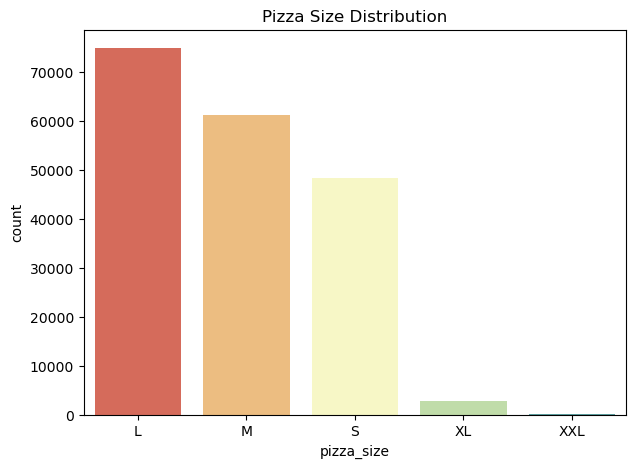

In [101]:
plt.figure(figsize=(7,5))
sns.countplot(x='pizza_size', data=merged_data, palette='Spectral', order=merged_data['pizza_size'].value_counts().index)
plt.title('Pizza Size Distribution')
plt.show()

C:\Users\osrnm\AppData\Local\Temp\ipykernel_4260\1011310189.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pizza_category', data=merged_data, palette='plasma', order=merged_data['pizza_category'].value_counts().index)


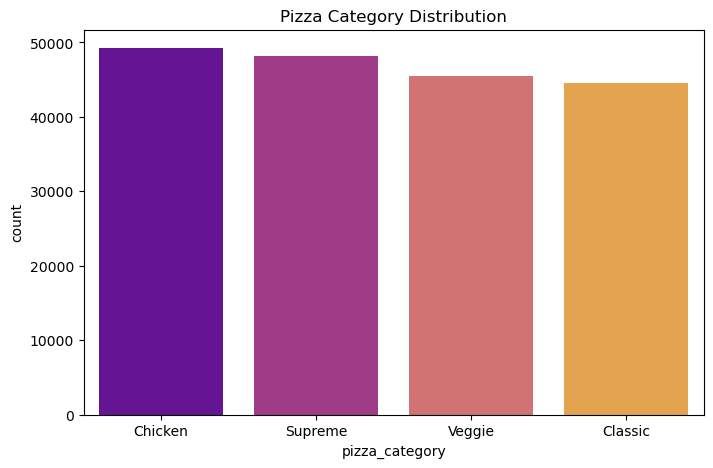

In [103]:
plt.figure(figsize=(8,5))
sns.countplot(x='pizza_category', data=merged_data, palette='plasma', order=merged_data['pizza_category'].value_counts().index)
plt.title('Pizza Category Distribution')
plt.show()

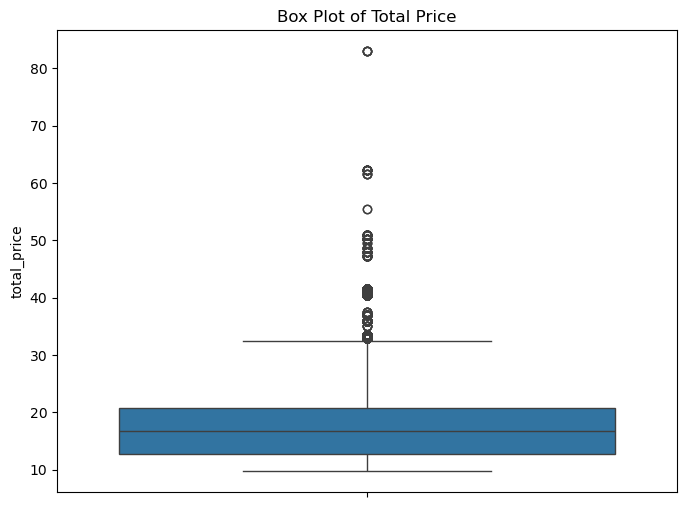

In [105]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=merged_data['total_price']) # Box plot of total price
plt.title('Box Plot of Total Price')
plt.show()

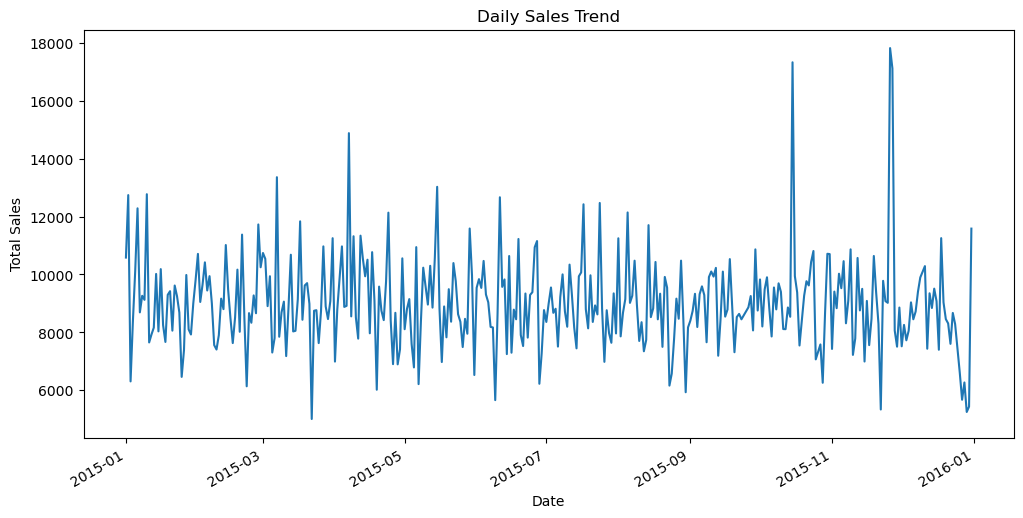

In [107]:
# Daily Sales Trend
daily_sales = merged_data.groupby('order_date')['total_price'].sum()
plt.figure(figsize=(12, 6))
daily_sales.plot()
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

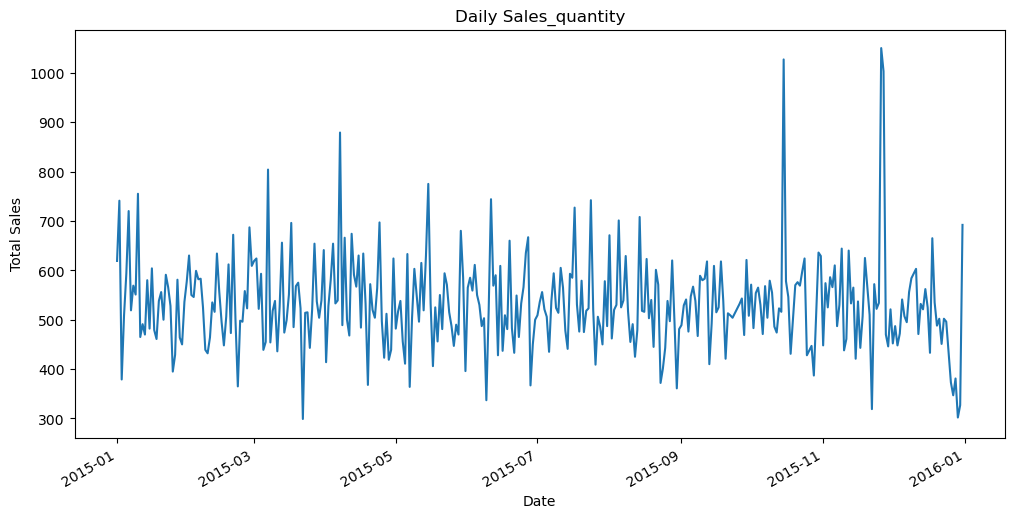

In [109]:
# Daily Sales Trend quantity wise
daily_sales = merged_data.groupby('order_date')['quantity'].sum()
plt.figure(figsize=(12, 6))
daily_sales.plot()
plt.title('Daily Sales_quantity')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [111]:
merged_data['order_date']

0        2015-01-01
1        2015-01-01
2        2015-01-01
3        2015-01-01
6        2015-01-01
            ...    
267565   2015-12-31
267567   2015-12-31
267570   2015-12-31
267571   2015-12-31
267573   2015-12-31
Name: order_date, Length: 187371, dtype: datetime64[ns]

In [113]:
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])
merged_data['month'] = merged_data['order_date'].dt.month
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()

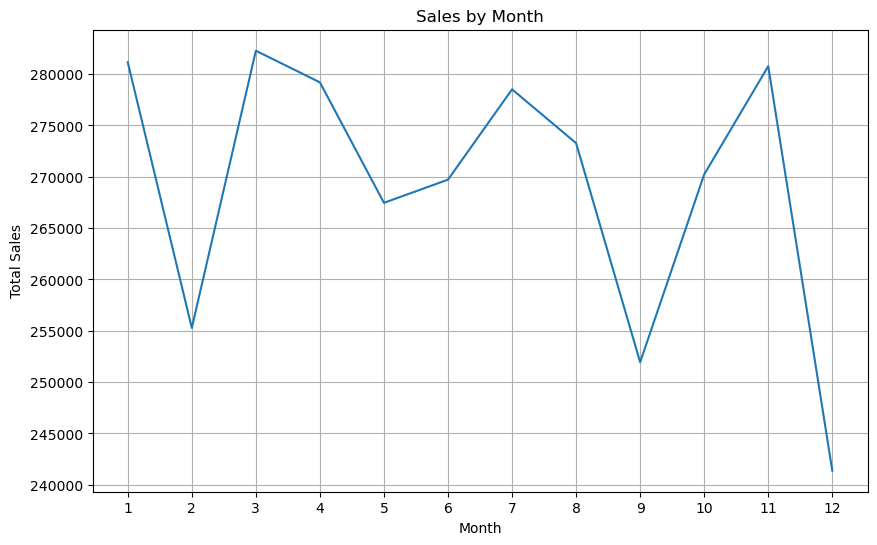

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(sales_by_month['month'], sales_by_month['total_price'])
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Sales by Month')
plt.xticks(sales_by_month['month'])
plt.grid(True)
plt.show()

C:\Users\osrnm\AppData\Local\Temp\ipykernel_4260\2446980298.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='total_price', data=sales_by_month, palette='viridis')


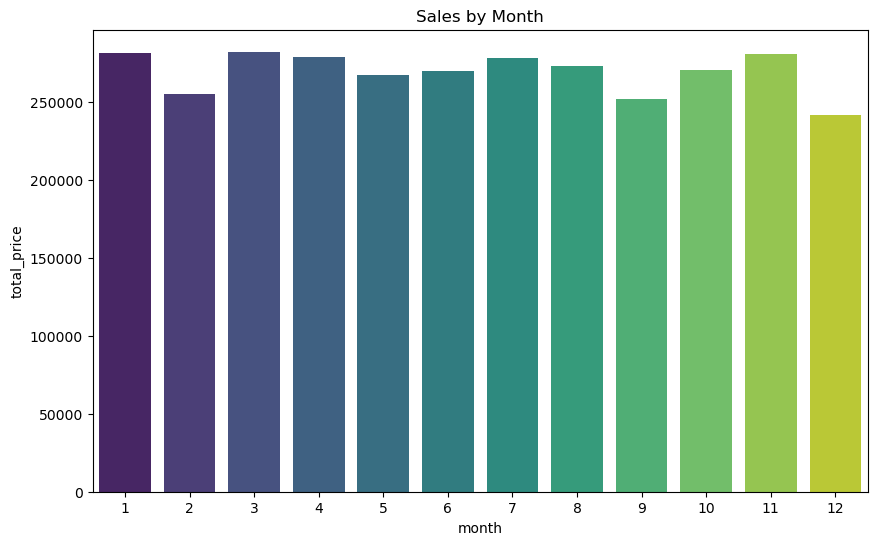

In [117]:
# Sales by Month

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_price', data=sales_by_month, palette='viridis')
plt.title('Sales by Month')
plt.show()

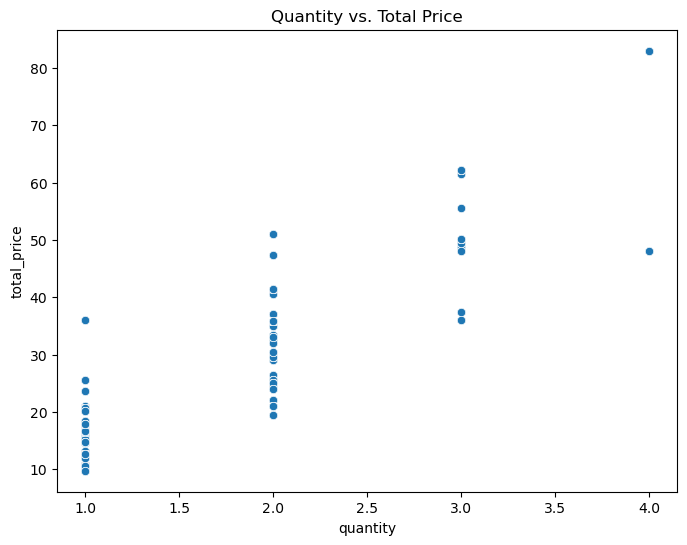

In [119]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='quantity', y='total_price', data=merged_data)
plt.title('Quantity vs. Total Price')
plt.show()

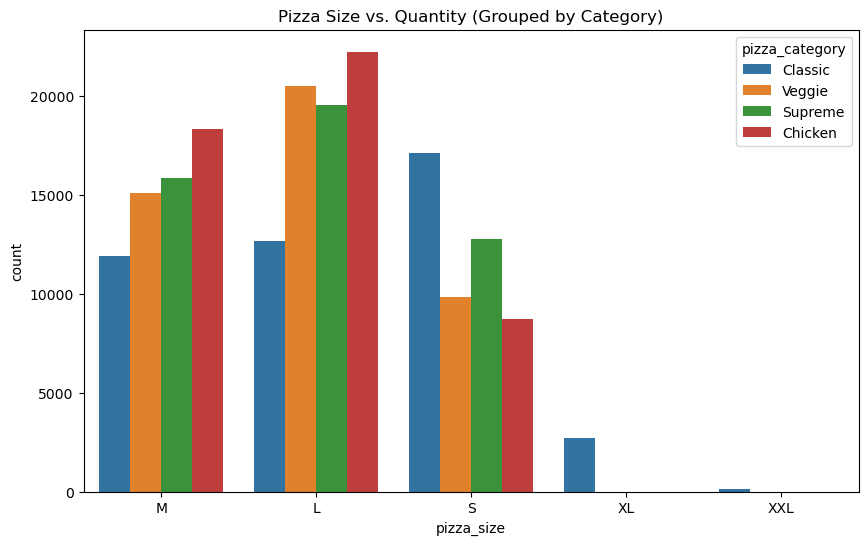

In [121]:
# Pizza Size vs. Quantity
plt.figure(figsize=(10, 6))
sns.countplot(x='pizza_size', hue='pizza_category', data=merged_data)
plt.title('Pizza Size vs. Quantity (Grouped by Category)')
plt.show()

In [123]:
merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

,pizza_name,quantity
0,The Barbecue Chicken Pizza,11192
1,The Big Meat Pizza,5739
2,The Brie Carre Pizza,1960
3,The Calabrese Pizza,3748
4,The California Chicken Pizza,11351
5,The Chicken Alfredo Pizza,4839
6,The Chicken Pesto Pizza,3892
7,The Classic Deluxe Pizza,7359
8,The Five Cheese Pizza,2818
9,The Four Cheese Pizza,8924


C:\Users\osrnm\AppData\Local\Temp\ipykernel_4260\3367269194.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='YlOrRd_r')


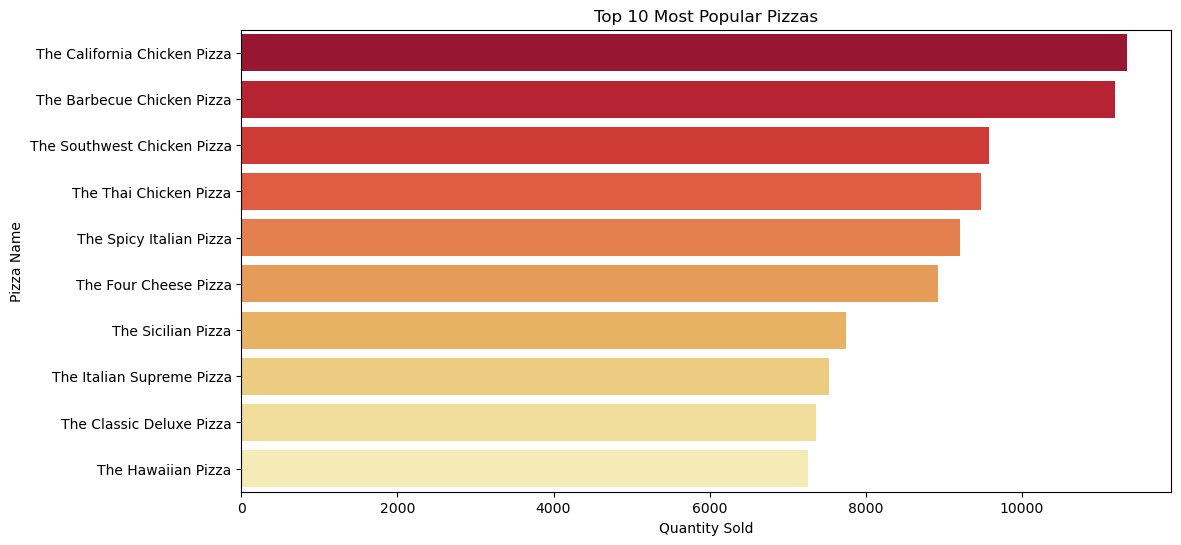

In [125]:
# Sorting by quantity sold
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas quantity wise
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='YlOrRd_r')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

In [139]:
merged_data.groupby('pizza_name')['total_price'].sum().reset_index()

,pizza_name,total_price
0,The Barbecue Chicken Pizza,201498.00
1,The Big Meat Pizza,68904.00
2,The Brie Carre Pizza,46354.00
3,The Calabrese Pizza,63737.00
4,The California Chicken Pizza,200685.25
5,The Chicken Alfredo Pizza,83277.25
6,The Chicken Pesto Pizza,66807.00
7,The Classic Deluxe Pizza,114541.50
8,The Five Cheese Pizza,52133.00
9,The Four Cheese Pizza,152685.00


In [141]:
merged_data.groupby('pizza_name')['total_price'].sum().sort_values(ascending=False)

pizza_name
The Barbecue Chicken Pizza                    201498.00
The California Chicken Pizza                  200685.25
The Thai Chicken Pizza                        173737.00
The Southwest Chicken Pizza                   173528.75
The Spicy Italian Pizza                       169068.75
The Four Cheese Pizza                         152685.00
The Greek Pizza                               134126.50
The Italian Supreme Pizza                     133907.00
The Pepper Salami Pizza                       127645.00
The Sicilian Pizza                            123762.00
The Vegetables + Vegetables Pizza             116305.75
The Classic Deluxe Pizza                      114541.50
The Mexicana Pizza                            107123.00
The Italian Capocollo Pizza                   100376.00
The Hawaiian Pizza                             96819.75
The Napolitana Pizza                           96348.00
The Spinach and Feta Pizza                     93085.00
The Chicken Alfredo Pizza            

C:\Users\osrnm\AppData\Local\Temp\ipykernel_4260\3257139851.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pizza_revenue.head(10), x='total_price', y='pizza_name', palette='viridis')


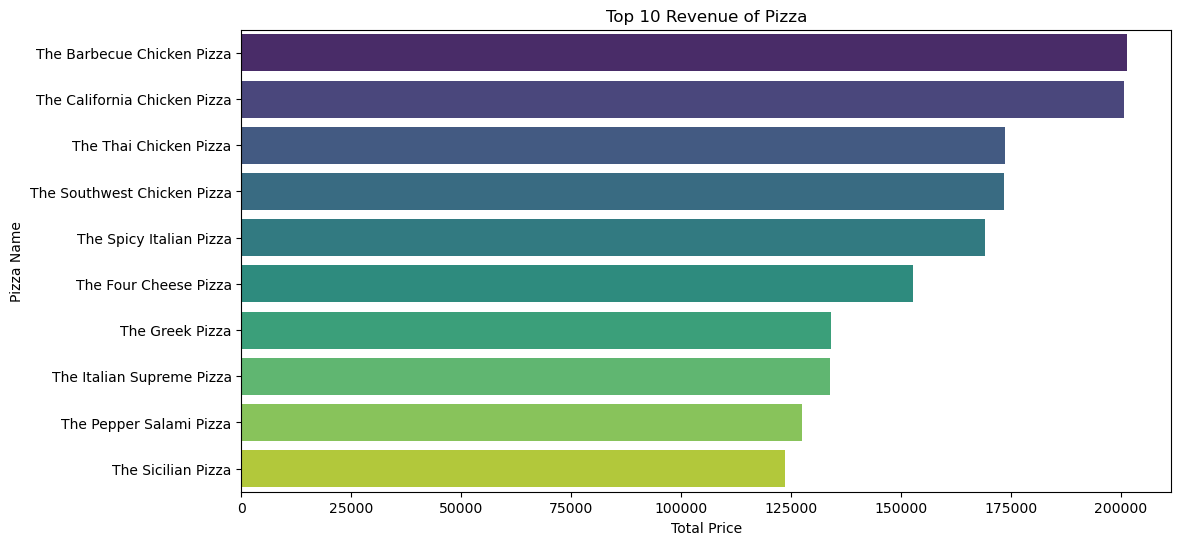

In [145]:
pizza_revenue = merged_data.groupby('pizza_name')['total_price'].sum().reset_index()
pizza_revenue = pizza_revenue.sort_values(by='total_price', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=pizza_revenue.head(10), x='total_price', y='pizza_name', palette='viridis')
plt.title('Top 10 Revenue of Pizza')
plt.xlabel('Total Price')
plt.ylabel('Pizza Name')
plt.show()

C:\Users\osrnm\AppData\Local\Temp\ipykernel_4260\446929438.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='holiday', y='total_price', data=merged_data, palette='bright')


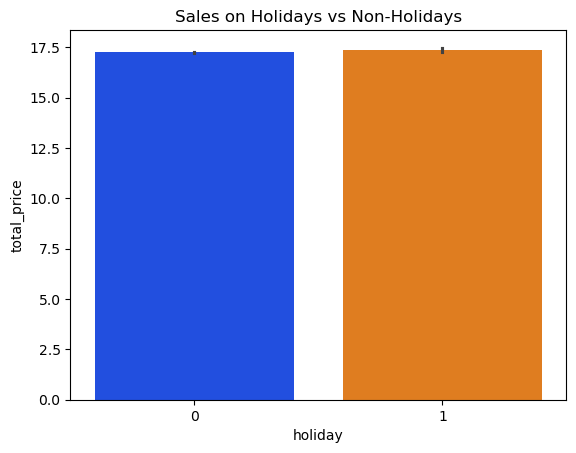

In [147]:
sns.barplot(x='holiday', y='total_price', data=merged_data, palette='bright')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

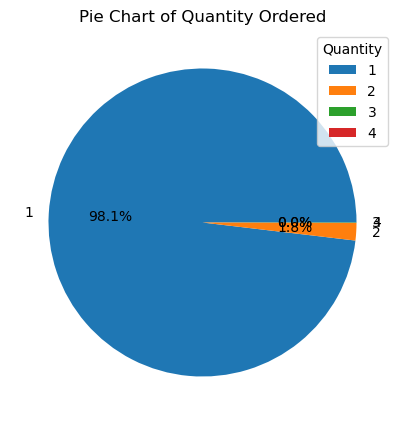

In [149]:
qty = merged_data['quantity'].value_counts().index
qty_counts = merged_data['quantity'].value_counts().values

plt.figure(figsize=(15, 5))
plt.pie(qty_counts, autopct='%1.1f%%', labels=qty) # Use qty_counts here and add labels
plt.legend(title="Quantity", labels=qty) # The labels parameter should be the quantity values
plt.title('Pie Chart of Quantity Ordered')
plt.show()

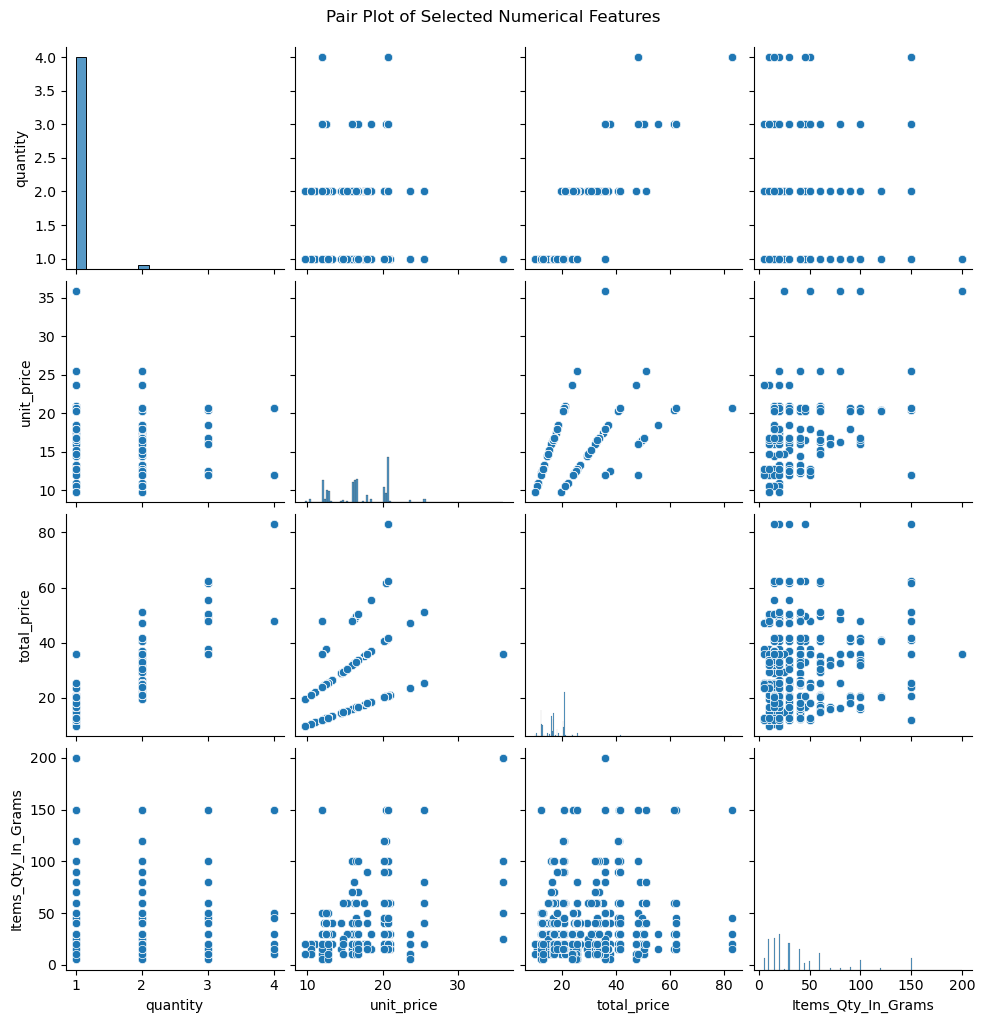

In [151]:
columns_for_pairplot = ['quantity', 'unit_price', 'total_price', 'Items_Qty_In_Grams']

# Create the pair plot
sns.pairplot(merged_data[columns_for_pairplot])  # Use your merged_data DataFrame
plt.suptitle('Pair Plot of Selected Numerical Features', y=1.02) # Adjust title position
plt.show()

Text(0.5, 1.0, 'Pizza Sale count as per order')

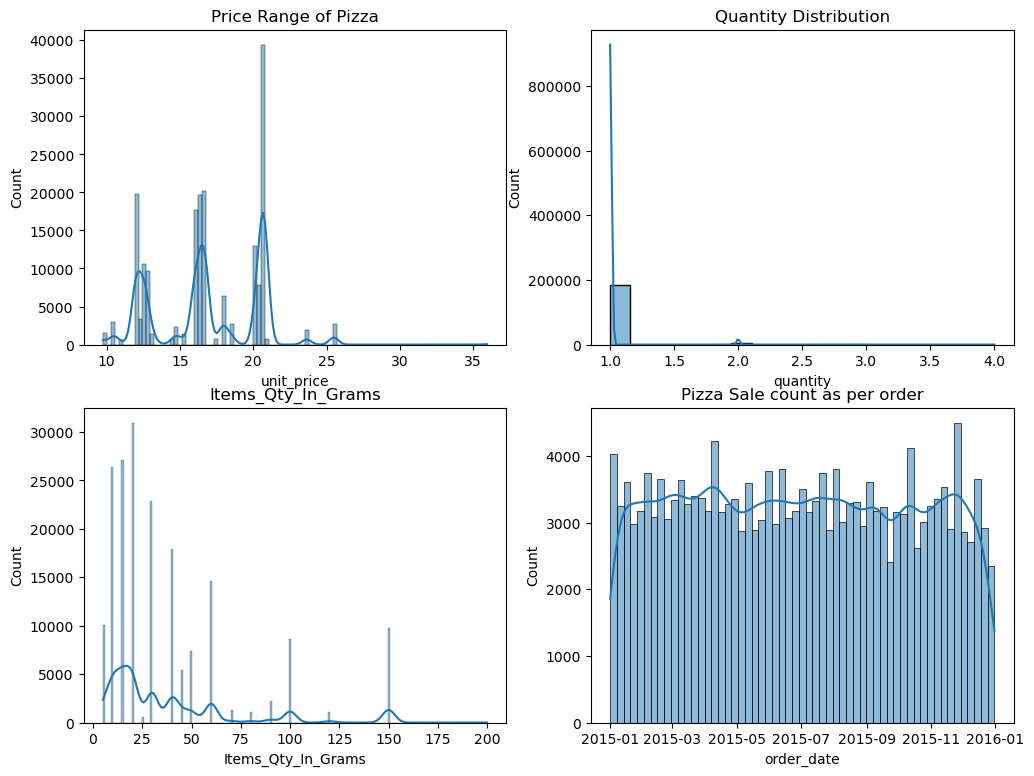

In [153]:
fig, axes = plt.subplots(2,2, figsize = (12,9))

sns.histplot(data=merged_data, x='unit_price', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Price Range of Pizza')

sns.histplot(data=merged_data, x='quantity', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Quantity Distribution')

sns.histplot(data=merged_data, x='Items_Qty_In_Grams', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Items_Qty_In_Grams')

sns.histplot(data=merged_data, x='order_date', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Pizza Sale count as per order')

In [169]:
merged_data.head()

,order_date,pizza_id,order_id,pizza_name_id,quantity,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,holiday,month
0,2015-01-01,1,1,hawaiian_m,1,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,40.0,1,1
1,2015-01-01,106,43,ital_supr_m,1,17:38:34,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,20.0,1,1
2,2015-01-01,106,43,ital_supr_m,1,17:38:34,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,40.0,1,1
3,2015-01-01,106,43,ital_supr_m,1,17:38:34,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,10.0,1,1
4,2015-01-01,107,43,peppr_salami_l,1,17:38:34,20.75,20.75,L,Supreme,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza,90.0,1,1


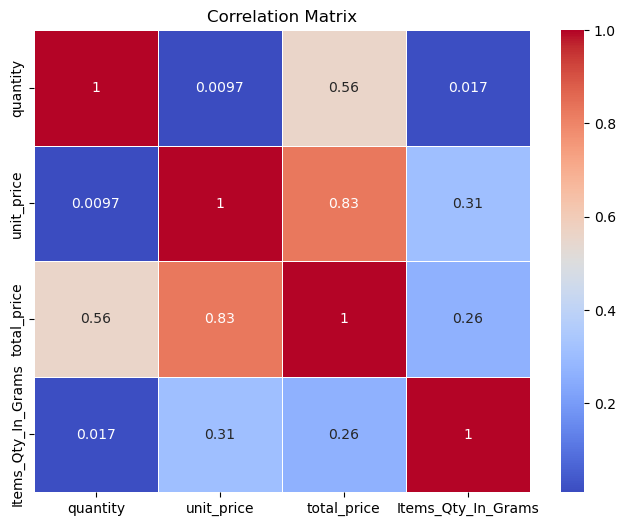

In [171]:
# Correlation matrix
corr_matrix = merged_data[['quantity', 'unit_price', 'total_price', 'Items_Qty_In_Grams']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [155]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187371 entries, 0 to 267573
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pizza_id            187371 non-null  int64         
 1   order_id            187371 non-null  int64         
 2   pizza_name_id       187371 non-null  object        
 3   quantity            187371 non-null  int64         
 4   order_date          187371 non-null  datetime64[ns]
 5   order_time          187371 non-null  object        
 6   unit_price          187371 non-null  float64       
 7   total_price         187371 non-null  float64       
 8   pizza_size          187371 non-null  object        
 9   pizza_category      187371 non-null  object        
 10  pizza_ingredients   187371 non-null  object        
 11  pizza_name          187371 non-null  object        
 12  Items_Qty_In_Grams  187371 non-null  float64       
 13  holiday             187371 non-nul

In [ ]:
merged_data.to_csv('merged_data.csv', index=False)

In [3]:
merged_data = pd.read_csv('merged_data.csv')

In [157]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187371 entries, 0 to 267573
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pizza_id            187371 non-null  int64         
 1   order_id            187371 non-null  int64         
 2   pizza_name_id       187371 non-null  object        
 3   quantity            187371 non-null  int64         
 4   order_date          187371 non-null  datetime64[ns]
 5   order_time          187371 non-null  object        
 6   unit_price          187371 non-null  float64       
 7   total_price         187371 non-null  float64       
 8   pizza_size          187371 non-null  object        
 9   pizza_category      187371 non-null  object        
 10  pizza_ingredients   187371 non-null  object        
 11  pizza_name          187371 non-null  object        
 12  Items_Qty_In_Grams  187371 non-null  float64       
 13  holiday             187371 non-nul

In [5]:
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])

In [173]:
merged_data = merged_data.set_index('order_date')
merged_data = merged_data.sort_index()  # Ensure it's sorted by date

In [175]:
merged_data['quantity'].resample('W').sum()

order_date
2015-01-04    2247
2015-01-11    4173
2015-01-18    3567
2015-01-25    3674
2015-02-01    3667
2015-02-08    3824
2015-02-15    3634
2015-02-22    3574
2015-03-01    3990
2015-03-08    3891
2015-03-15    3647
2015-03-22    3697
2015-03-29    3688
2015-04-05    3890
2015-04-12    4215
2015-04-19    3806
2015-04-26    3777
2015-05-03    3531
2015-05-10    2970
2015-05-17    3974
2015-05-24    3692
2015-05-31    3555
2015-06-07    3887
2015-06-14    3690
2015-06-21    3612
2015-06-28    3782
2015-07-05    3578
2015-07-12    3775
2015-07-19    3831
2015-07-26    3766
2015-08-02    3640
2015-08-09    3961
2015-08-16    3592
2015-08-23    3655
2015-08-30    3355
2015-09-06    3630
2015-09-13    3785
2015-09-20    3718
2015-09-27    2601
2015-10-04    3771
2015-10-11    3693
2015-10-18    4095
2015-10-25    3365
2015-11-01    3056
2015-11-08    3878
2015-11-15    3702
2015-11-22    3509
2015-11-29    4597
2015-12-06    3428
2015-12-13    3241
2015-12-20    3729
2015-12-27    2671
2

In [177]:
weekly_sales_quantity = merged_data['quantity'].resample('W').sum()

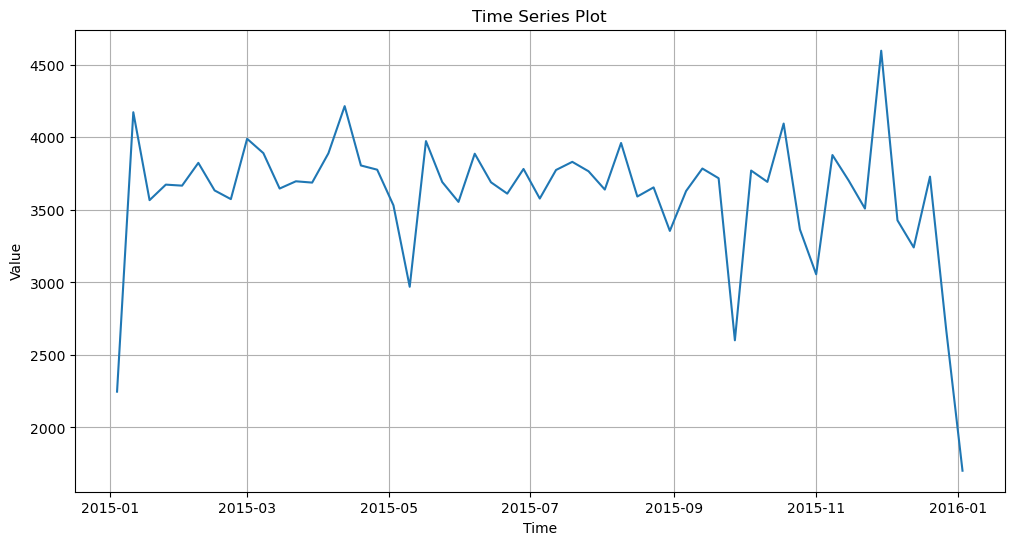

In [179]:
def plot_time_series(series, title="Time Series Plot"):
    plt.figure(figsize=(12, 6))
    plt.plot(series)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

# Example usage (replace pizza_sales_weekly with your series)
plot_time_series(weekly_sales_quantity)

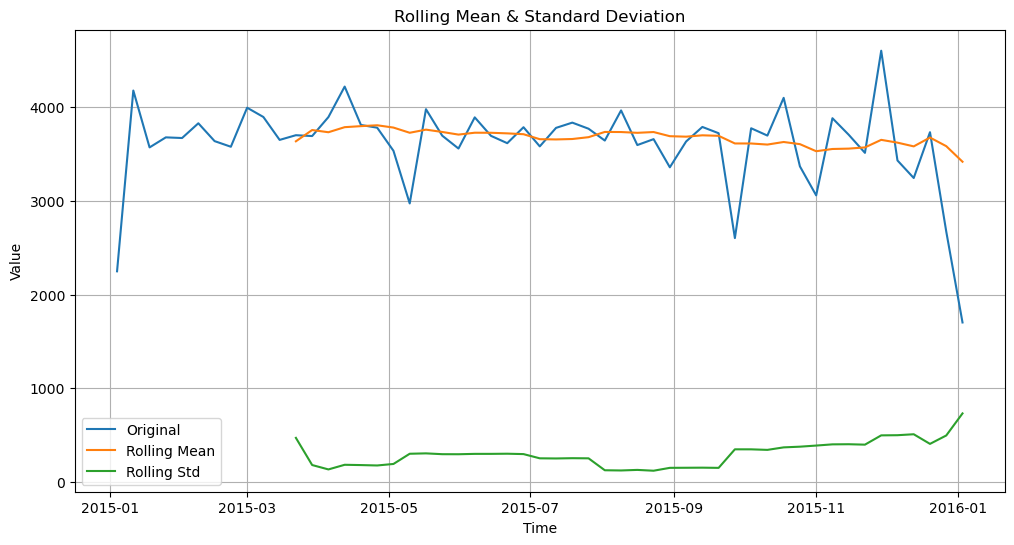

In [181]:
def plot_rolling_stats(series, window=12, title="Rolling Mean & Standard Deviation"):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, label="Original")
    plt.plot(rolling_mean, label="Rolling Mean")
    plt.plot(rolling_std, label="Rolling Std")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_rolling_stats(weekly_sales_quantity)

In [183]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title="Augmented Dickey-Fuller Test"):
    result = adfuller(series)
    print(f"ADF Test: {title}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print("Result: The time series is stationary.")
    else:
        print("Result: The time series is non-stationary.")

# Example usage
adf_test(weekly_sales_quantity)

ADF Test: Augmented Dickey-Fuller Test
ADF Statistic: -5.843774172582588
p-value: 3.7245677084569037e-07
Critical Values: {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}
Result: The time series is stationary.


In [185]:
int(0.8 * len(weekly_sales_quantity))

42

In [187]:
train_size = int(0.8 * len(weekly_sales_quantity))
train, test = weekly_sales_quantity[:train_size], weekly_sales_quantity[train_size:]

In [ ]:
pip install statsmodels

In [ ]:
pip install pmdarima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [189]:
import itertools

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sar

Best ARIMA Model MAPE: 0.1982, Best Parameters: (5, 1, 4)
Predictions:
order_date
2015-10-25    3472.411399
2015-11-01    3806.171189
2015-11-08    3636.718734
2015-11-15    3651.013043
2015-11-22    3563.143183
2015-11-29    3858.148367
2015-12-06    3541.433690
2015-12-13    3660.302750
2015-12-20    3652.514197
2015-12-27    3807.612170
2016-01-03    3475.182481
Freq: W-SUN, Name: predicted_mean, dtype: float64


C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


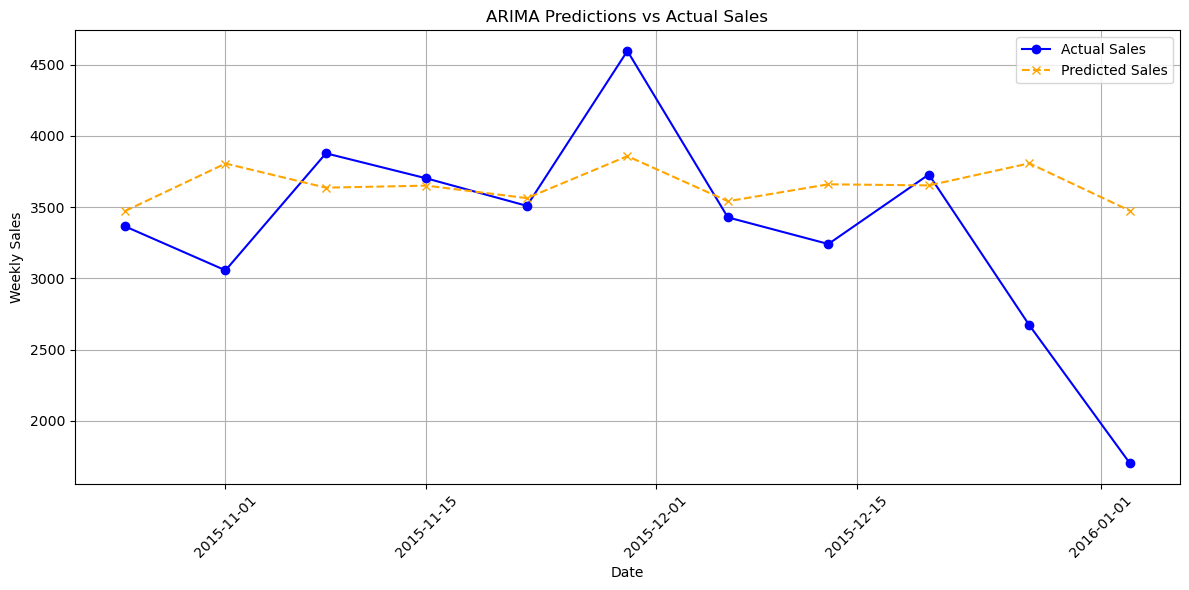

In [191]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [193]:
from pmdarima import auto_arima

def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

def auto_sarima_model(train, test):
    model = auto_arima(train, seasonal=True, m=7,  # m=7 for weekly seasonality
                       suppress_warnings=True, trace=True)  # trace = True to see the search process
    predictions = model.predict(n_periods=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Auto-SARIMA Model MAPE: {sarima_mape:.4f}")
    print(f"Best Parameters: {model.order}, {model.seasonal_order}")
    return predictions, sarima_mape

# Train and evaluate the Auto-SARIMA model
sarima_predictions, sarima_mape_score = auto_sarima_model(train, test)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=615.108, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=617.475, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=811.016, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=617.107, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=616.520, Time=0.16 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=615.476, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=615.055, Time=0.12 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=617.021, Time=0.37 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=617.192, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=617.032, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=619.051, Time=0.20 se

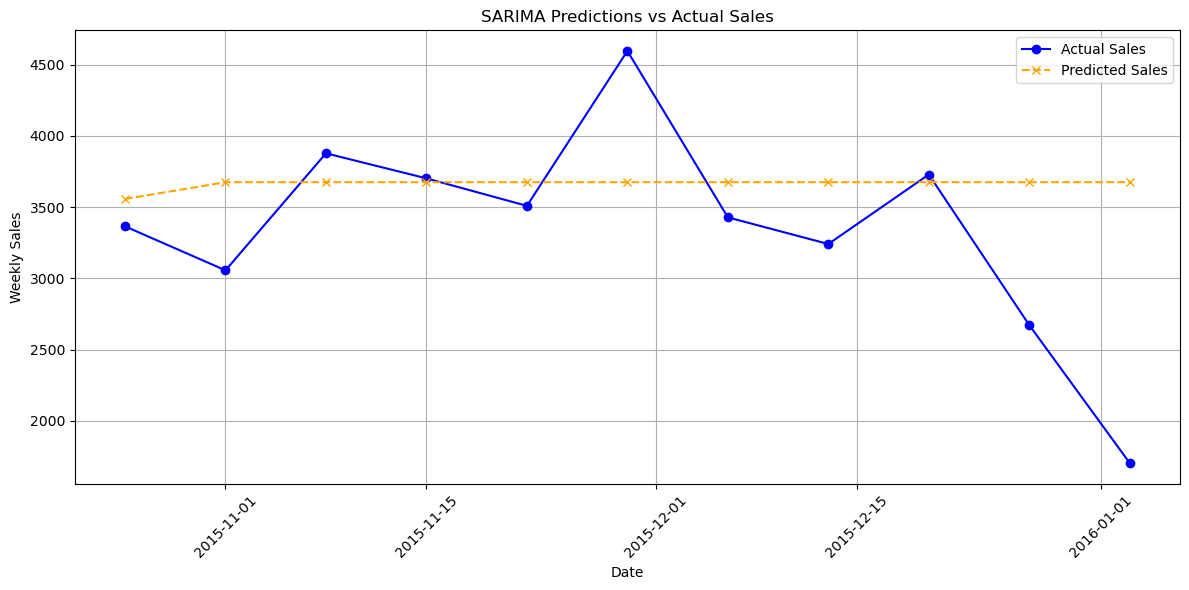

In [195]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [197]:
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

def tune_sarima_model(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
        try:
            model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=False)
            predictions = model.forecast(steps=len(test))
            sarima_mape = mape(test, predictions)
            if sarima_mape < best_score:
                best_score, best_params, best_predictions = sarima_mape, (p, d, q, P, D, Q, s), predictions
        except:
            continue

    print(f"Best SARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

# Define parameter ranges (adjust as needed)
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
s_values = [7]  # Example seasonal period (7 for weekly)

# Train and evaluate the SARIMA model with hyperparameter tuning
sarima_predictions, sarima_mape_score, best_params = tune_sarima_model(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s_values)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)
print(f"Best Parameters: {best_params}")

C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\

Best SARIMA Model MAPE: 0.1841, Best Parameters: (1, 1, 3, 0, 1, 0, 7)
Predictions:
order_date
2015-10-25    3491.915119
2015-11-01    3912.259305
2015-11-08    3560.435309
2015-11-15    2728.258987
2015-11-22    3613.435627
2015-11-29    3820.258669
2015-12-06    3937.435946
2015-12-13    3619.173470
2015-12-20    3754.695569
2015-12-27    3687.693341
2016-01-03    2570.695569
Freq: W-SUN, Name: predicted_mean, dtype: float64
Best Parameters: (1, 1, 3, 0, 1, 0, 7)


C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


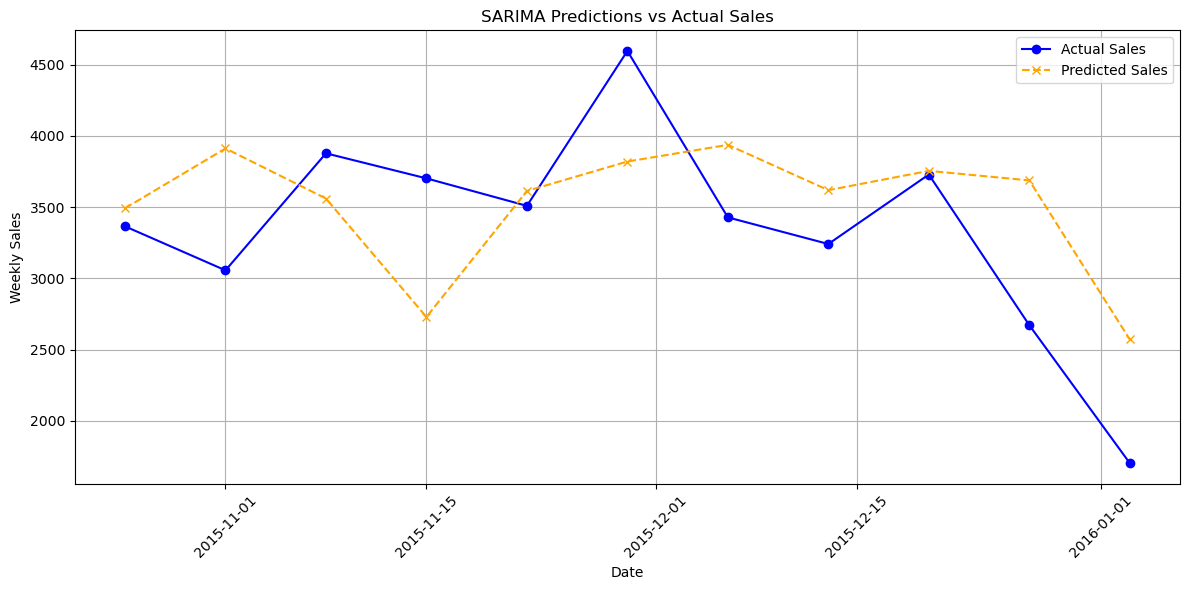

In [27]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [199]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def tune_ets_model(train, test, trend_values, seasonal_values, seasonal_periods):
    best_score, best_params, best_predictions = float("inf"), None, None

    for trend, seasonal, seasonal_period in itertools.product(trend_values, seasonal_values, seasonal_periods):
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period).fit()
            predictions = model.forecast(steps=len(test))
            ets_mape = mape(test, predictions)
            if ets_mape < best_score:
                best_score, best_params, best_predictions = ets_mape, (trend, seasonal, seasonal_period), predictions
        except:
            continue

    print(f"Best ETS Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

# Define parameter ranges
trend_values = ['add', 'mul', None]
seasonal_values = ['add', 'mul', None]
seasonal_periods = [7] #weekly data

ets_predictions, ets_mape_score, best_params = tune_ets_model(train, test, trend_values, seasonal_values, seasonal_periods)

ets_predictions = pd.Series(ets_predictions, index=test.index)
print("ETS Predictions:")
print(ets_predictions)

Best ETS Model MAPE: 0.1889, Best Parameters: ('mul', 'mul', 7)
ETS Predictions:
order_date
2015-10-25    3475.700758
2015-11-01    3805.673171
2015-11-08    3613.621058
2015-11-15    3409.102177
2015-11-22    3482.902111
2015-11-29    3617.118905
2015-12-06    3618.732389
2015-12-13    3429.171821
2015-12-20    3754.726918
2015-12-27    3565.245792
2016-01-03    3363.464790
Freq: W-SUN, dtype: float64


C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


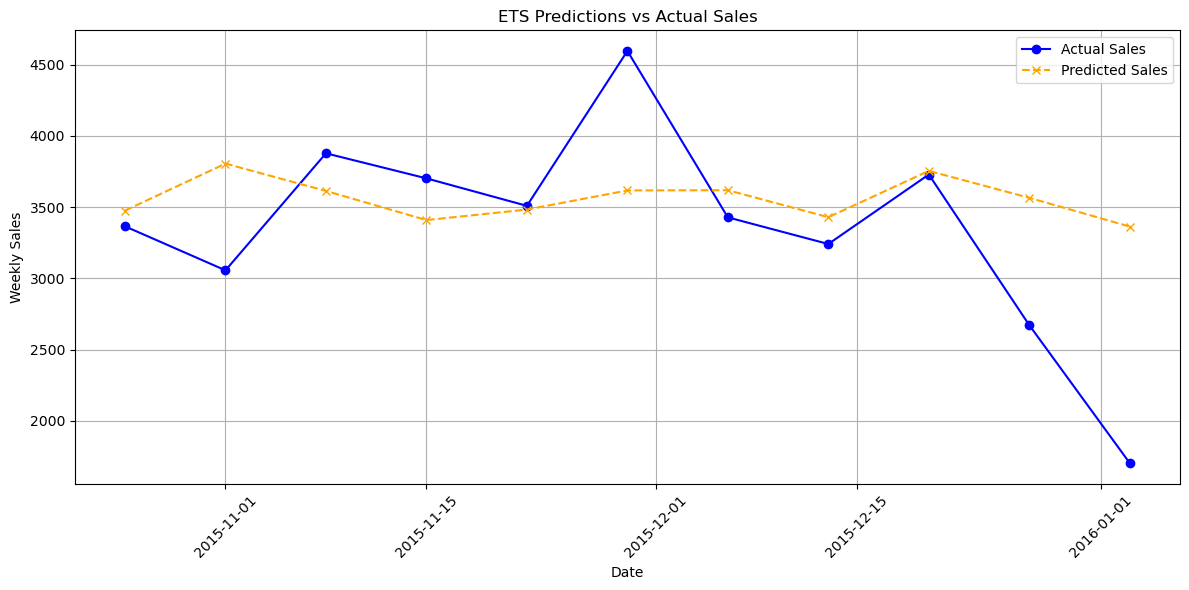

In [200]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(ets_predictions.index, ets_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ETS Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
pip install prophet

In [203]:
from prophet import Prophet

def tune_prophet_model(train, test):
    #Prophet does not need tuning in the same way, but parameters can be set.
    train_df = pd.DataFrame({'ds': train.index, 'y': train.values})
    test_df = pd.DataFrame({'ds': test.index, 'y': test.values})

    model = Prophet()
    model.fit(train_df)
    forecast = model.make_future_dataframe(periods=len(test), freq=test.index.freq)
    predictions = model.predict(forecast)
    prophet_predictions = predictions['yhat'][-len(test):].values
    prophet_mape = mape(test, prophet_predictions)

    print(f"Prophet Model MAPE: {prophet_mape:.4f}")
    return prophet_predictions, prophet_mape

prophet_predictions, prophet_mape_score = tune_prophet_model(train, test)

prophet_predictions = pd.Series(prophet_predictions, index=test.index)
print("Prophet Predictions:")
print(prophet_predictions)

14:32:48 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model MAPE: 0.2155
Prophet Predictions:
order_date
2015-10-25    3680.226063
2015-11-01    3680.757719
2015-11-08    3681.289376
2015-11-15    3681.821033
2015-11-22    3682.352689
2015-11-29    3682.884346
2015-12-06    3683.416003
2015-12-13    3683.947659
2015-12-20    3684.479316
2015-12-27    3685.010972
2016-01-03    3685.542629
Freq: W-SUN, dtype: float64


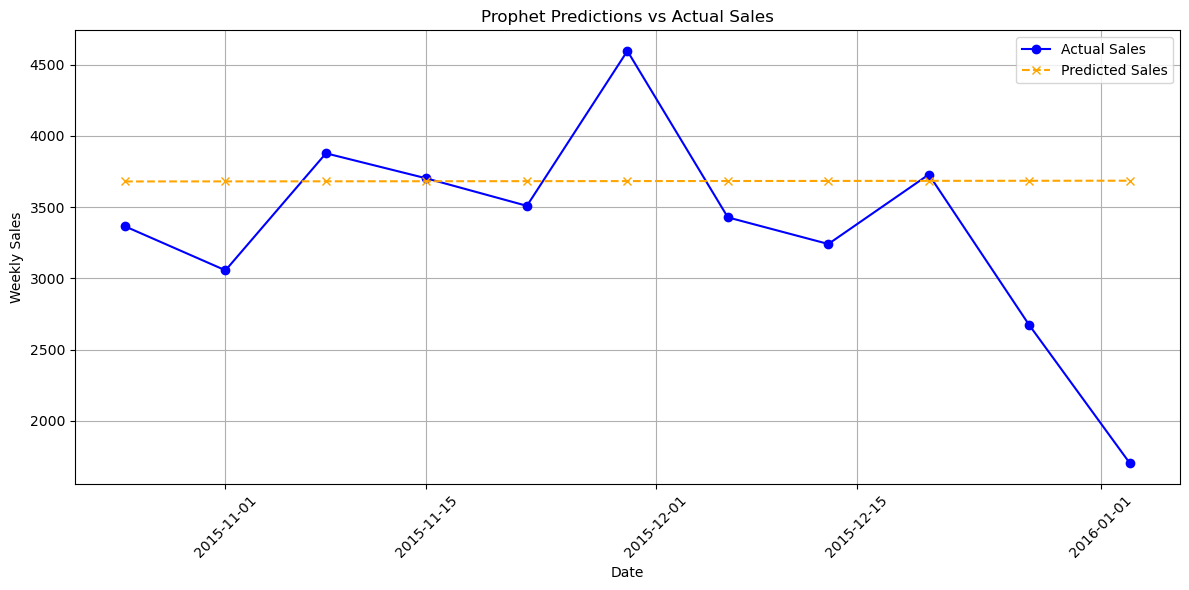

In [204]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [207]:

# Model results as a dictionary
model_performance = {
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'ETS'],
    'MAPE': [0.1982, 0.1841, 0.2155, 0.1889]
}

# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)

# Display table
df_performance

,Model,MAPE,Rank
1,SARIMA,0.1841,1.0
3,ETS,0.1889,2.0
0,ARIMA,0.1982,3.0
2,Prophet,0.2155,4.0


In [209]:
merged_data = merged_data.reset_index()

In [211]:
merged_data.head()

,order_date,pizza_id,order_id,pizza_name_id,quantity,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,holiday,month
0,2015-01-01,1,1,hawaiian_m,1,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,40.0,1,1
1,2015-01-01,106,43,ital_supr_m,1,17:38:34,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,20.0,1,1
2,2015-01-01,106,43,ital_supr_m,1,17:38:34,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,40.0,1,1
3,2015-01-01,106,43,ital_supr_m,1,17:38:34,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,10.0,1,1
4,2015-01-01,107,43,peppr_salami_l,1,17:38:34,20.75,20.75,L,Supreme,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza,90.0,1,1


In [213]:
merged_data['week'] = merged_data['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
merged_data.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()

,week,pizza_name_id,quantity
0,2014-12-29,bbq_ckn_l,60
1,2014-12-29,bbq_ckn_m,65
2,2014-12-29,bbq_ckn_s,6
3,2014-12-29,big_meat_s,60
4,2014-12-29,brie_carre_s,16
...,...,...,...
4749,2015-12-28,the_greek_s,4
4750,2015-12-28,the_greek_xl,20
4751,2015-12-28,veggie_veg_l,30
4752,2015-12-28,veggie_veg_m,20


In [214]:
weekly_sales_by_pizza = merged_data.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
weekly_sales_by_pizza.set_index('week', inplace=True)

In [215]:
weekly_sales_by_pizza

,pizza_name_id,quantity
week,,
2014-12-29,bbq_ckn_l,60
2014-12-29,bbq_ckn_m,65
2014-12-29,bbq_ckn_s,6
2014-12-29,big_meat_s,60
2014-12-29,brie_carre_s,16
...,...,...
2015-12-28,the_greek_s,4
2015-12-28,the_greek_xl,20
2015-12-28,veggie_veg_l,30


In [39]:
# Function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 1, 3), seasonal_order=(0, 1, 0, 7))
    model_fit = model.fit(disp=False)
    
    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(weekly_sales_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = weekly_sales_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = weekly_sales_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in weekly_sales_by_pizza['pizza_name_id'].unique():
        pizza_type_data = weekly_sales_by_pizza[weekly_sales_by_pizza['pizza_name_id'] == pizza_type]
        
        # train test data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(weekly_sales_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Displaying the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON w

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 69 pizzas
bbq_ckn_m: 108 pizzas
bbq_ckn_s: 31 pizzas
big_meat_s: 98 pizzas
brie_carre_s: 37 pizzas
calabrese_l: 15 pizzas
calabrese_m: 29 pizzas
cali_ckn_l: 93 pizzas
cali_ckn_m: 103 pizzas
cali_ckn_s: 21 pizzas
ckn_alfredo_l: 14 pizzas
ckn_alfredo_m: 64 pizzas
ckn_alfredo_s: 14 pizzas
ckn_pesto_l: 42 pizzas
ckn_pesto_m: 23 pizzas
ckn_pesto_s: 16 pizzas
classic_dlx_l: 31 pizzas
classic_dlx_m: 58 pizzas
classic_dlx_s: 44 pizzas
five_cheese_l: 48 pizzas
four_cheese_l: 162 pizzas
four_cheese_m: 37 pizzas
green_garden_l: 6 pizzas
green_garden_m: 43 pizzas
green_garden_s: 37 pizzas
hawaiian_l: 31 pizzas
hawaiian_m: 3 pizzas
hawaiian_s: 58 pizzas
ital_cpcllo_l: 65 pizzas
ital_cpcllo_m: 61 pizzas
ital_cpcllo_s: 45 pizzas
ital_supr_l: 37 pizzas
ital_supr_m: 96 pizzas
ital_supr_s: 9 pizzas
ital_veggie_m: 41 pizzas
ital_veggie_s: 20 pizzas
mediterraneo_l: 20 pizzas
mediterraneo_m: 22 pizzas
mediterraneo_s: 26 pizzas
mexicana_l: 7

C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\osrnm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Final Results and Predictions

In [221]:
model = SARIMAX(train, order=(1, 1, 3), seasonal_order=(0, 1, 0, 7)).fit(disp=False)

In [223]:
# Forecasting function
def forecast_sales(model, periods):
    forecast = model.forecast(steps=periods)
    #forecast = model.predict(n_periods=periods)
    return forecast

forecasted_sales = forecast_sales(model, periods=7)
print(forecasted_sales)

2015-10-25    3491.915119
2015-11-01    3912.259305
2015-11-08    3560.435309
2015-11-15    2728.258987
2015-11-22    3613.435627
2015-11-29    3820.258669
2015-12-06    3937.435946
Freq: W-SUN, Name: predicted_mean, dtype: float64


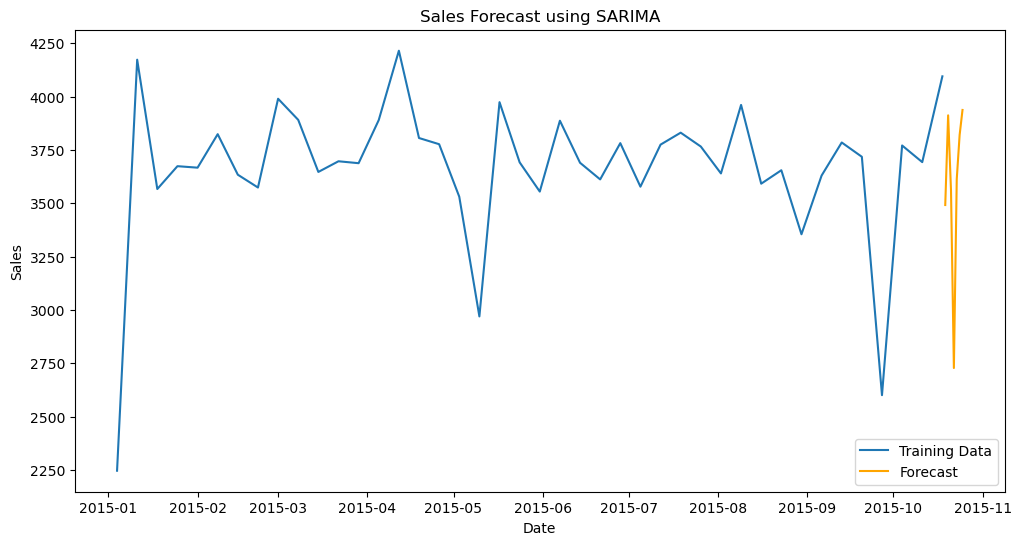

In [57]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=7), forecasted_sales, label='Forecast', color='orange')
plt.title('Sales Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [77]:

# Copy ingredients, map predicted sales, and calculateing the total ingredient quantity
ingredients_predicted = ingr.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']



In [87]:
# Sum of the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
print(ingredient_totals)
ingredients_predicted

Total quantity of predicted ingredients for the following week:
{'?duja Salami': 2140.0, 'Alfredo Sauce': 1380.0, 'Anchovies': 3510.0, 'Artichokes': 10170.0, 'Arugula': 695.0, 'Asiago Cheese': 5460.0, 'Bacon': 26420.0, 'Barbecue Sauce': 2270.0, 'Barbecued Chicken': 6620.0, 'Beef Chuck Roast': 18230.0, 'Blue Cheese': 1440.0, 'Brie Carre Cheese': 1110.0, 'Calabrese Salami': 15600.0, 'Capocollo': 64150.0, 'Caramelized Onions': 740.0, 'Chicken': 85600.0, 'Chipotle Sauce': 7360.0, 'Chorizo Sausage': 4900.0, 'Cilantro': 3680.0, 'Coarse Sicilian Salami': 11080.0, 'Corn': 24610.0, 'Eggplant': 1920.0, 'Feta Cheese': 11930.0, 'Fontina Cheese': 6350.0, 'Friggitello Peppers': 535.0, 'Garlic': 26125.0, 'Genoa Salami': 5400.0, 'Goat Cheese': 15820.0, 'Gorgonzola Piccante Cheese': 7220.0, 'Gouda Cheese': 5060.0, 'Green Olives': 4895.0, 'Green Peppers': 7595.0, 'Italian Sausage': 980.0, 'Jalapeno Peppers': 6210.0, 'Kalamata Olives': 3985.0, 'Luganega Sausage': 5540.0, 'Mozzarella Cheese': 10970.0, 'Mu

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,69,2760.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,69,1035.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,69,1380.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,69,2070.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,69,4140.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,56,1120.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,56,1120.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,56,560.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,56,840.0


In [89]:
ingredient_totals

{'?duja Salami': 2140.0,
 'Alfredo Sauce': 1380.0,
 'Anchovies': 3510.0,
 'Artichokes': 10170.0,
 'Arugula': 695.0,
 'Asiago Cheese': 5460.0,
 'Bacon': 26420.0,
 'Barbecue Sauce': 2270.0,
 'Barbecued Chicken': 6620.0,
 'Beef Chuck Roast': 18230.0,
 'Blue Cheese': 1440.0,
 'Brie Carre Cheese': 1110.0,
 'Calabrese Salami': 15600.0,
 'Capocollo': 64150.0,
 'Caramelized Onions': 740.0,
 'Chicken': 85600.0,
 'Chipotle Sauce': 7360.0,
 'Chorizo Sausage': 4900.0,
 'Cilantro': 3680.0,
 'Coarse Sicilian Salami': 11080.0,
 'Corn': 24610.0,
 'Eggplant': 1920.0,
 'Feta Cheese': 11930.0,
 'Fontina Cheese': 6350.0,
 'Friggitello Peppers': 535.0,
 'Garlic': 26125.0,
 'Genoa Salami': 5400.0,
 'Goat Cheese': 15820.0,
 'Gorgonzola Piccante Cheese': 7220.0,
 'Gouda Cheese': 5060.0,
 'Green Olives': 4895.0,
 'Green Peppers': 7595.0,
 'Italian Sausage': 980.0,
 'Jalapeno Peppers': 6210.0,
 'Kalamata Olives': 3985.0,
 'Luganega Sausage': 5540.0,
 'Mozzarella Cheese': 10970.0,
 'Mushrooms': 27320.0,
 'Onions

In [91]:
# Saveing the ingredient totals to a DataFrame
ingredient_totals_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_totals_df.to_csv('predicted_ingredient_totals.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


In [93]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (grams)
0,?duja Salami,2140.0
1,Alfredo Sauce,1380.0
2,Anchovies,3510.0
3,Artichokes,10170.0
4,Arugula,695.0
...,...,...
59,Sun-dried Tomatoes,975.0
60,Thai Sweet Chilli Sauce,4150.0
61,Thyme,185.0
62,Tomatoes,50680.0
